# Imports and setup

In [2]:
# This is a boilerplate bulk import - not all will be used
# Base libraries
import pandas as pd
import time
from datetime import date, timedelta
import os

# Scientific libraries
import numpy as np
import pandas as pd
from empiricaldist import Cdf, Pmf
import scipy.stats as stats
import pymc3 as pm


# Visual libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import missingno as msno  # Visualize missing values

# Helper libraries
from tqdm.notebook import tqdm, trange
from colorama import Fore, Back, Style
import warnings
warnings.filterwarnings('ignore')

# Visual setup
import matplotlib.ticker as ticker
plt.style.use('ggplot')
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['figure.figsize'] = [12, 9]
rcParams['font.size'] = 16
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
custom_colors = ['#74a09e','#86c1b2','#98e2c6','#f3c969','#f2a553', '#d96548', '#c14953']
sns.set_palette(custom_colors)
%config InlineBackend.figure_format = 'retina'
%config Completer.use_jedi = False

# Pandas options
pd.set_option('max_colwidth', 40)
pd.options.display.max_columns = None  # Possible to limit
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Seed value for numpy.random
np.random.seed(42)

In [3]:
df = pd.read_csv('/Users/jasperdean/Downloads/virtual-convenience-experiment.csv')

In [6]:
print(len(df))

100000


# Primer section

### Context, business & customer problem, motivation/theory 

 - Not all shoppers have same broad JTBD in coming to instacart
   - Kitchen sink model not necessarily optimal
   - Default experience is the ‘everything everywhere all at once’ approach
 - Trying to be hired for wider range of jobs
   - be hired more consistently
   - complete them more effectively
 - Principle Idea is to slim down offering and improve speed in return
   - Built virtual convenience store
 - Secondary idea is to lower barrier to entry (purchase size)
   - Convenience store purchases are often smaller than at grocers, so additionally experimented with reducing minimum cart size
 - Goals
   - Customer level profitability
   - But for sake of assignment, customer level revenue
 - Extensions
   - Customer acquisition
   - Customer retention
 - Hypothesis: trading selection variety for speed, and lower cart minimums will increase customer spend/profitability


### Hypotheses

first null hypothesis = "There is no relationship between which instacart experience a customer had and their spending rate. They are independent."

first alternate hypothesis = "There is a relationship between which instacart experience a customer had and their spending rate. They are not independent."

second null hypothesis = "There is no relationship between the minimum basket size and spending rate. They are independent."

second alternate hypothesis = "There is a relationship between the minimum basket size and signup rate. They are not independent."

#### Why we should use a two tailed test

It's possible that our variants could end up either higher or lower (in terms of spending, our key metric) than the default ecperinece mean. A two tailed test allows us to observe that possibility

### Planned confidence level

In [2]:
alpha = 0.05

### Exploratory data analysis

In [7]:
df.head()

,user_id,assignment_date,express,loyalty,zip_code,address_type,experiment_group,grp_code,orders_placed,avg_order_value,total_spend
0,1,2022-01-18,0,0,37214,Residential,variant 2 (VC $10 min),v2,1,141.89,141.89
1,2,2022-02-22,1,0,37209,Residential,control (no VC $35 min),c0,1,71.15,71.15
2,3,2022-01-15,1,1,37217,Residential,control (no VC $35 min),c0,6,189.84,1139.07
3,4,2022-02-17,0,0,37215,Residential,variant 1 (VC $35 min),v1,0,0.00,0.00
4,5,2022-02-06,0,0,37211,Residential,variant 2 (VC $10 min),v2,1,58.21,58.21


In [10]:
df.describe()

,user_id,express,loyalty,zip_code,orders_placed,avg_order_value,total_spend
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000
mean,50000.500000,0.493730,0.170110,37211.642660,1.47960,78.111245,179.053389
std,28867.657797,0.499963,0.375731,5.218981,1.63954,76.982609,242.310199
min,1.000000,0.000000,0.000000,37201.000000,0.00000,0.000000,0.000000
25%,25000.750000,0.000000,0.000000,37207.000000,0.00000,0.000000,0.000000
50%,50000.500000,0.000000,0.000000,37211.000000,1.00000,69.135000,104.140000
75%,75000.250000,1.000000,0.000000,37215.000000,2.00000,132.930000,252.010000
max,100000.000000,1.000000,1.000000,37240.000000,13.00000,466.210000,3104.460000


In [11]:
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 0 users that appear multiple times in the dataset


In [12]:
df.grp_code.value_counts()

c0    49715
v2    25151
v1    25134
Name: grp_code, dtype: int64

In [13]:
df.groupby('grp_code').avg_order_value.mean()

grp_code
c0    78.806962
v1    78.344144
v2    76.503307
Name: avg_order_value, dtype: float64

In [14]:
df.groupby('grp_code').total_spend.mean()

grp_code
c0    174.160120
v1    177.518201
v2    190.259873
Name: total_spend, dtype: float64

In [75]:
df.groupby('grp_code').orders_placed.mean()

grp_code
c0    1.378759
v1    1.448397
v2    1.710111
Name: orders_placed, dtype: float64

In [15]:
df.groupby(["grp_code", "address_type"]).size()

grp_code  address_type
c0        Business         3987
          Residential     45728
v1        Business         2039
          Residential     23095
v2        Business         1974
          Residential     23177
dtype: int64

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
user_id             100000 non-null int64
assignment_date     100000 non-null object
express             100000 non-null int64
loyalty             100000 non-null int64
zip_code            100000 non-null int64
address_type        100000 non-null object
experiment_group    100000 non-null object
grp_code            100000 non-null object
orders_placed       100000 non-null int64
avg_order_value     100000 non-null float64
total_spend         100000 non-null float64
dtypes: float64(2), int64(5), object(4)
memory usage: 8.4+ MB


In [10]:
no_orders = df[df['orders_placed'] == 0]
no_orders.groupby(["grp_code", "total_spend"]).size()
df.grp_code.value_counts()

grp_code  total_spend
c0        0.0            18664
v1        0.0             8979
v2        0.0             7756
dtype: int64

c0    49715
v2    25151
v1    25134
Name: grp_code, dtype: int64

Early good news - each variant successively increased the % of customers who placed any size order

c0            18664/49715 = 37.5%  
v1             8979/25134 = 35.7%  
v2             7756/25151 = 30.8%  

### Basic vis

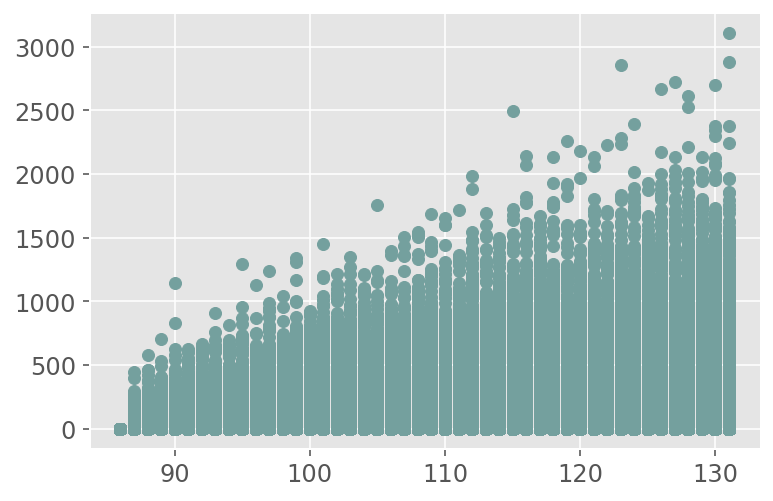

In [5]:
x = df.time_in_experiment
y = df.total_spend
plt.scatter(x, y)
plt.show()

(array([20885.,  5243.,  5623.,  4228.,  2982.,  2123.,  1687.,  1339.,
         1058.]),
 array([  0.        ,  55.55555556, 111.11111111, 166.66666667,
        222.22222222, 277.77777778, 333.33333333, 388.88888889,
        444.44444444, 500.        ]),
 <a list of 9 Patch objects>)

(array([10228.,  2813.,  2902.,  2128.,  1430.,  1112.,   883.,   749.,
          570.]),
 array([  0.        ,  55.55555556, 111.11111111, 166.66666667,
        222.22222222, 277.77777778, 333.33333333, 388.88888889,
        444.44444444, 500.        ]),
 <a list of 9 Patch objects>)

(array([10228.,  2813.,  2902.,  2128.,  1430.,  1112.,   883.,   749.,
          570.]),
 array([  0.        ,  55.55555556, 111.11111111, 166.66666667,
        222.22222222, 277.77777778, 333.33333333, 388.88888889,
        444.44444444, 500.        ]),
 <a list of 9 Patch objects>)

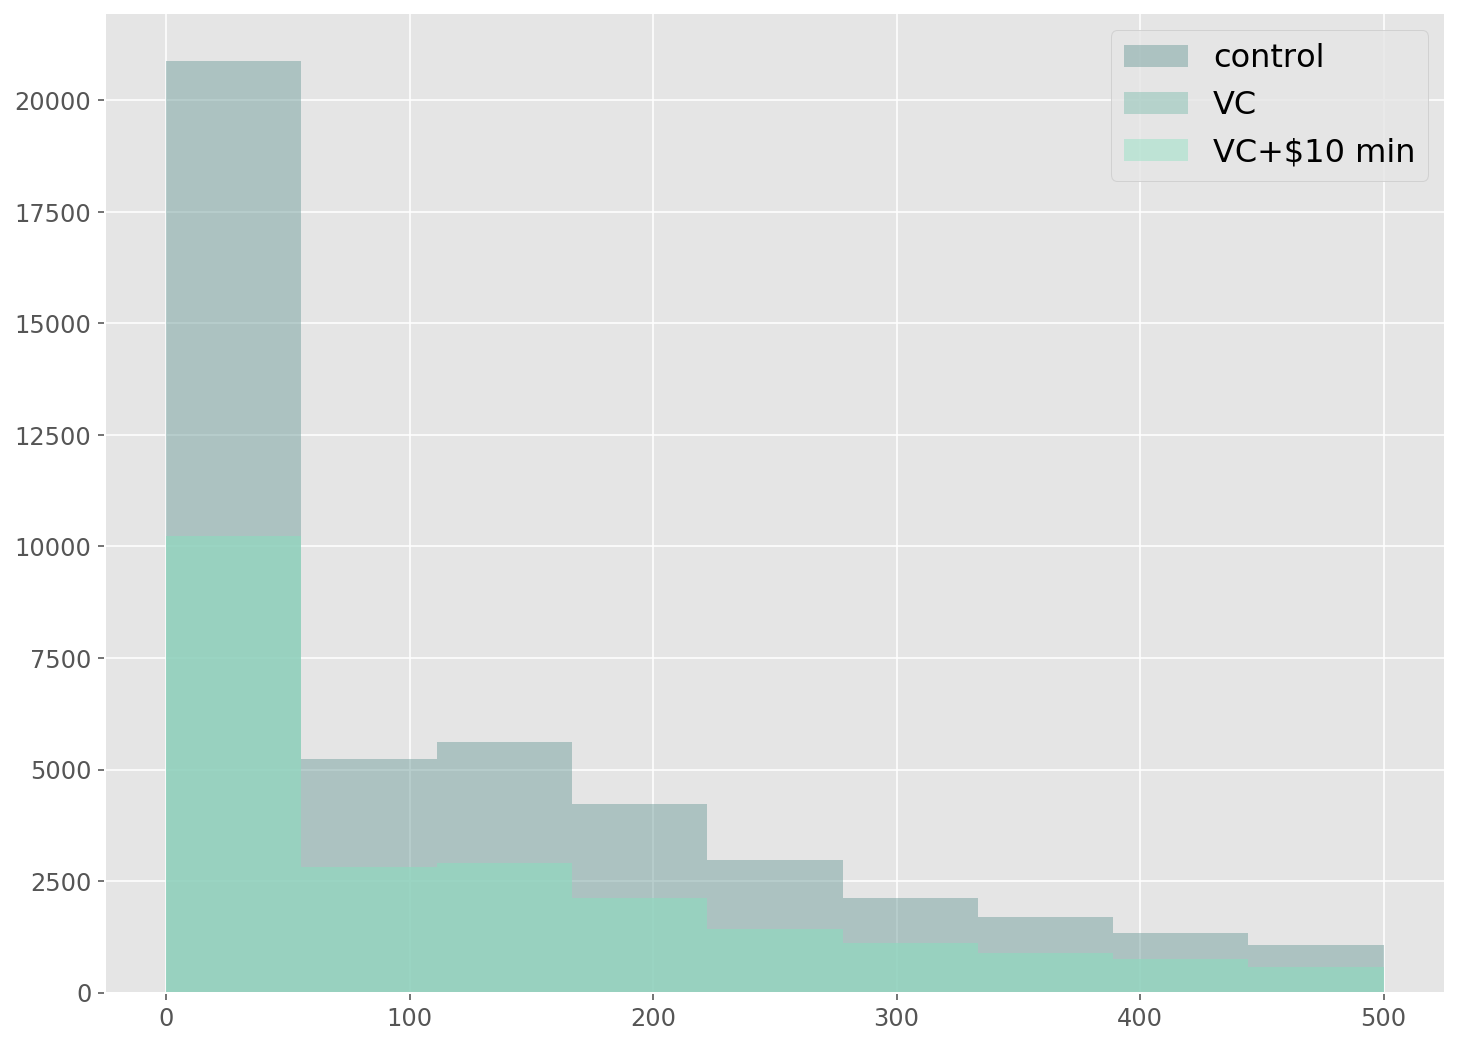

In [18]:
from matplotlib import pyplot

# x = [random.gauss(3,1) for _ in range(400)]
# y = [random.gauss(4,2) for _ in range(400)]
x = df[df['grp_code'] == 'c0']['total_spend']
y = df[df['grp_code'] == 'v1']['total_spend']
z = df[df['grp_code'] == 'v2']['total_spend']

bins = np.linspace(0, 500, 10)

pyplot.hist(x, bins, alpha=0.5, label='control')
pyplot.hist(y, bins, alpha=0.5, label='VC')
pyplot.hist(y, bins, alpha=0.5, label='VC+$10 min')
pyplot.legend(loc='upper right')
pyplot.show()

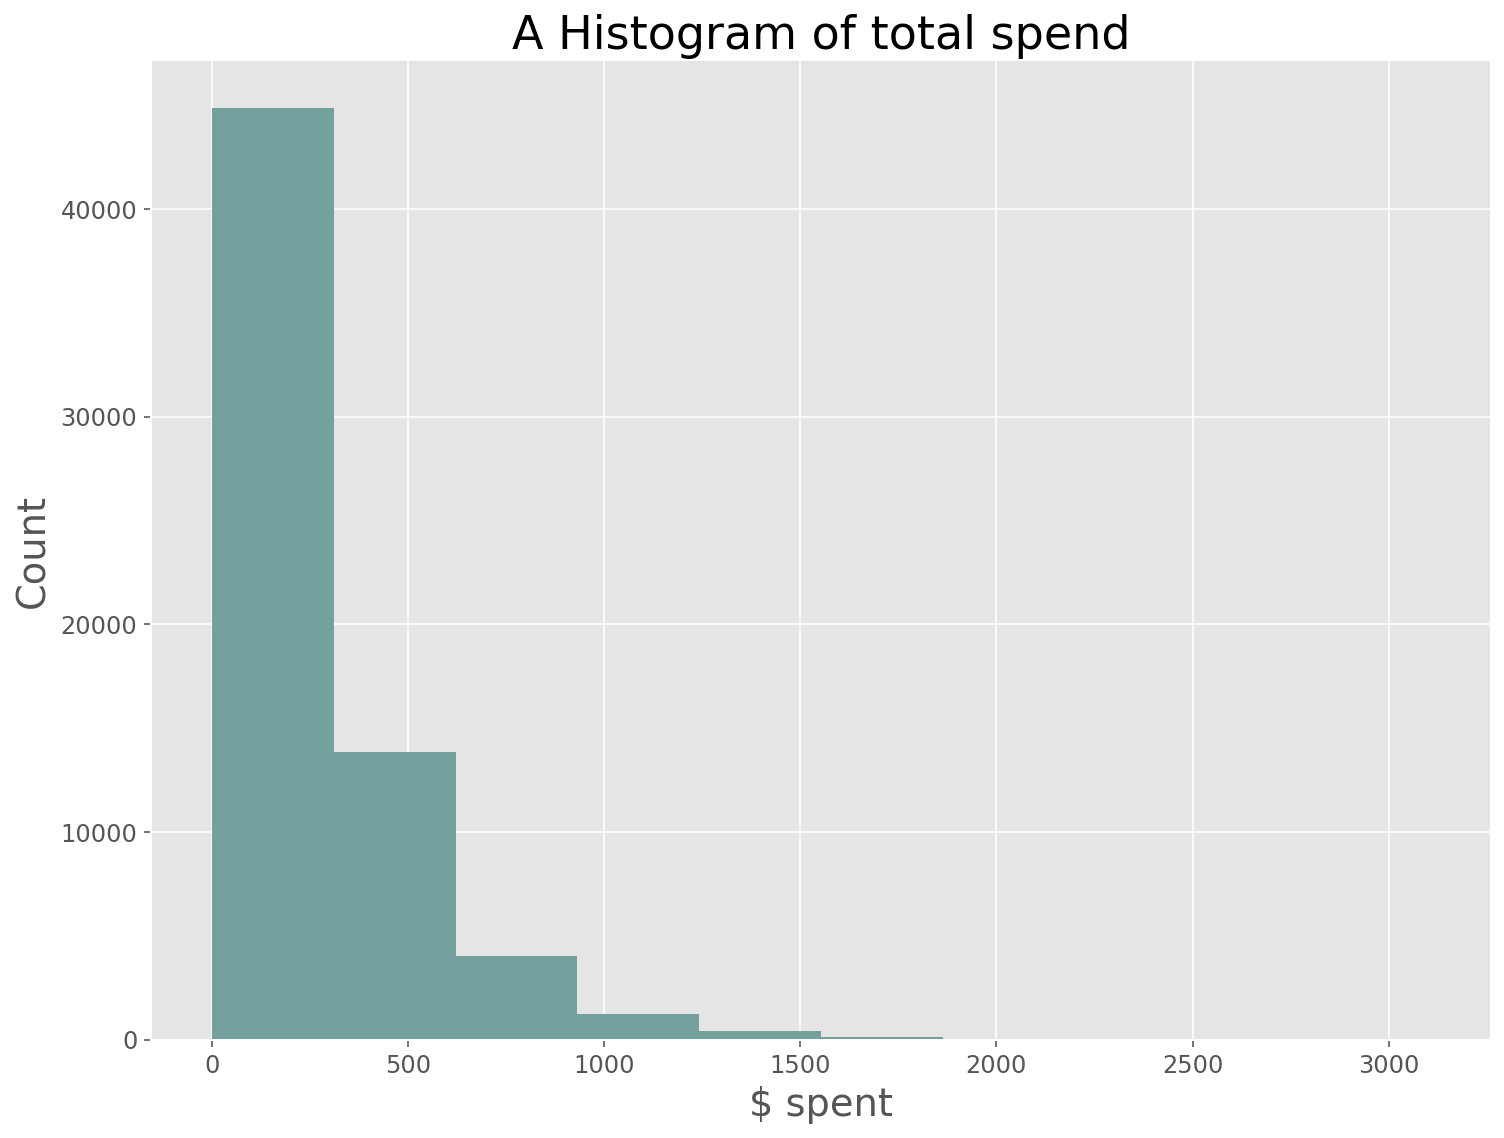

In [19]:
fig, ax = plt.subplots()

# Subset for ratings over 0
over_0 = df[df['total_spend'] > 0]['total_spend']

# Plot a histogram
ax.hist(over_0, bins=10)

# Label
ax.set(title='A Histogram of total spend',
       xlabel='$ spent',
       ylabel='Count')

plt.show();

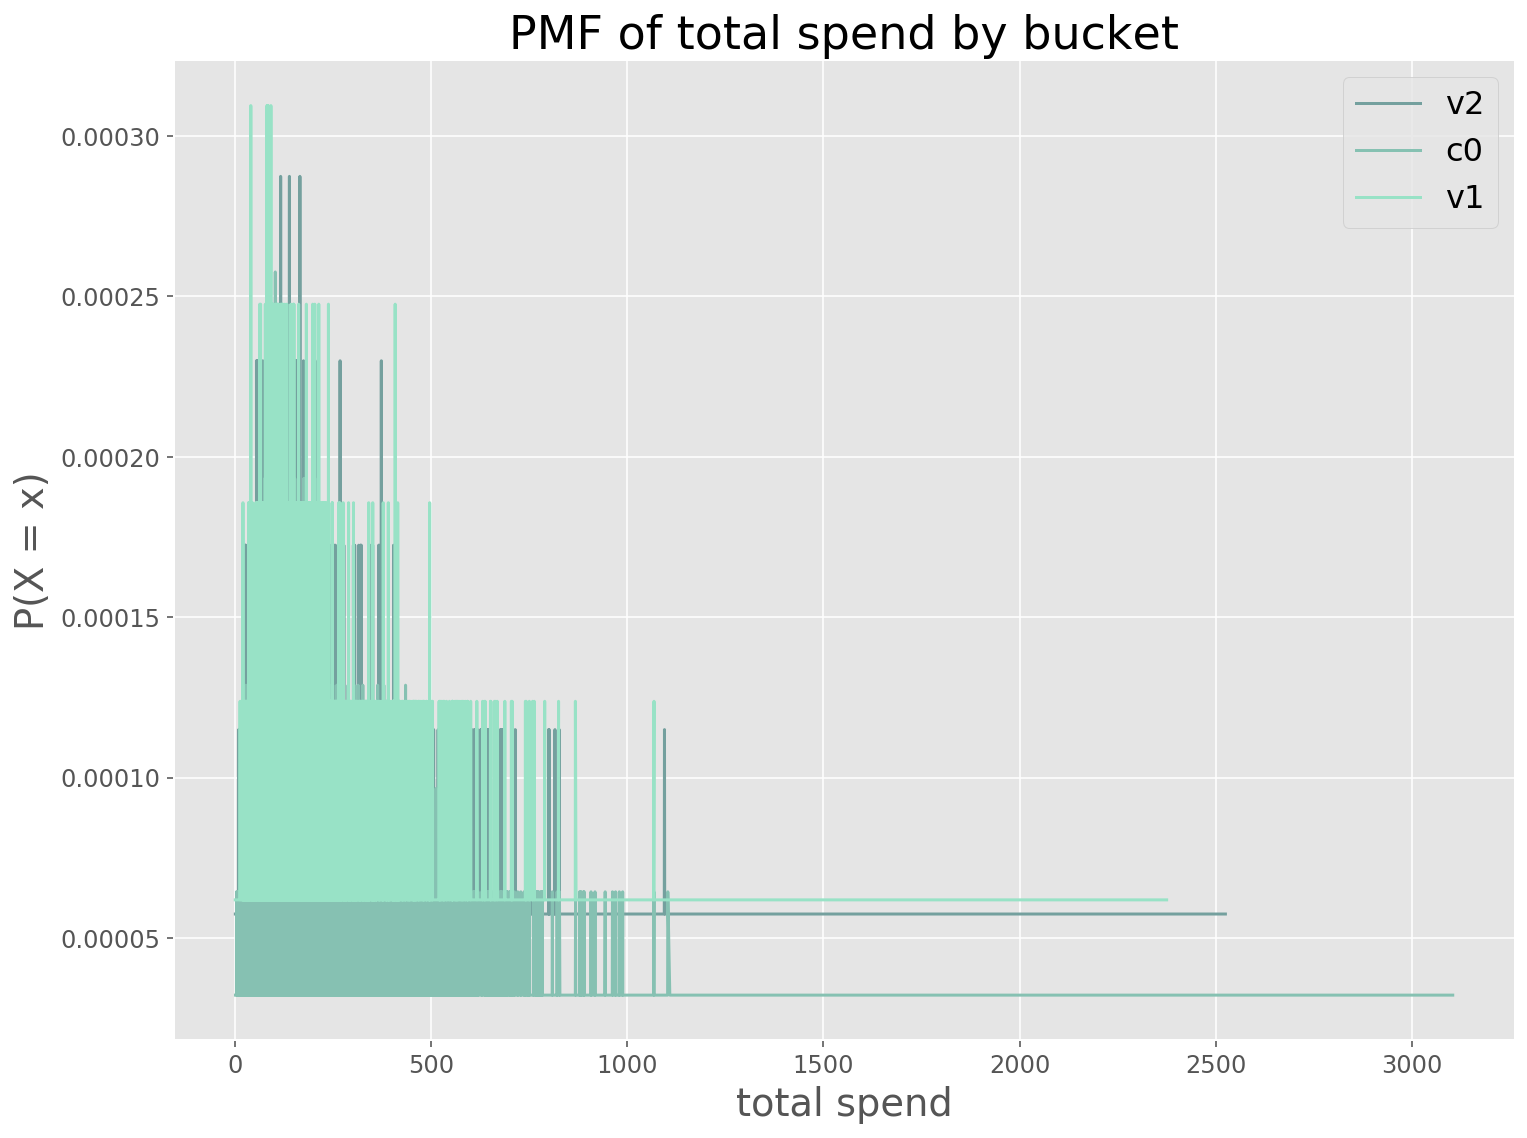

In [82]:
fig, ax = plt.subplots()
# Extract the unique categories
buckets = df['grp_code'].unique()
# Filter out 0 ordders placed ratings
table = df[df['total_spend'] > 0]

for buck in buckets:
    pmf_buck = Pmf.from_seq(table[table['grp_code'] == buck]['total_spend'])
    ax.plot(pmf_buck, label=buck)

ax.set(title='PMF of total spend by bucket',
       xlabel='total spend',
       ylabel='P(X = x)')

ax.legend()

plt.show();

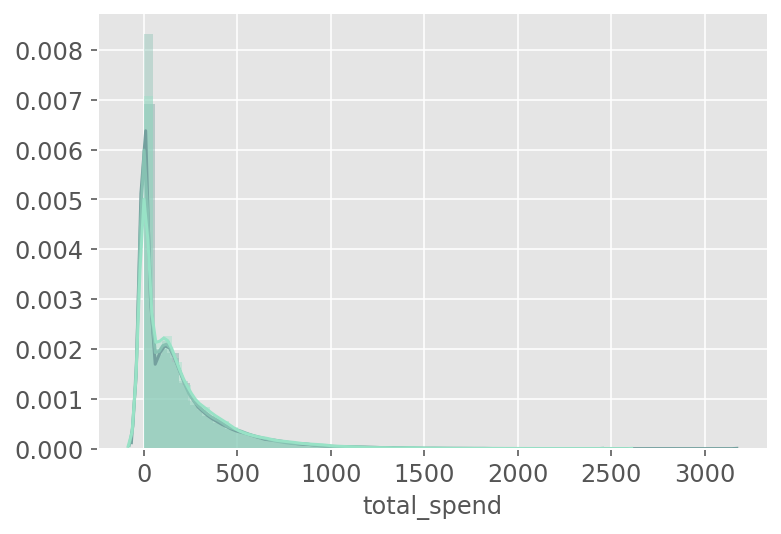

In [7]:
x = df[df['grp_code'] == 'c0']['total_spend']
y = df[df['grp_code'] == 'v1']['total_spend']
z = df[df['grp_code'] == 'v2']['total_spend']
sns.distplot(x)
sns.distplot(y)
sns.distplot(z)

AttributeError: 'Rectangle' object has no property 'bins'

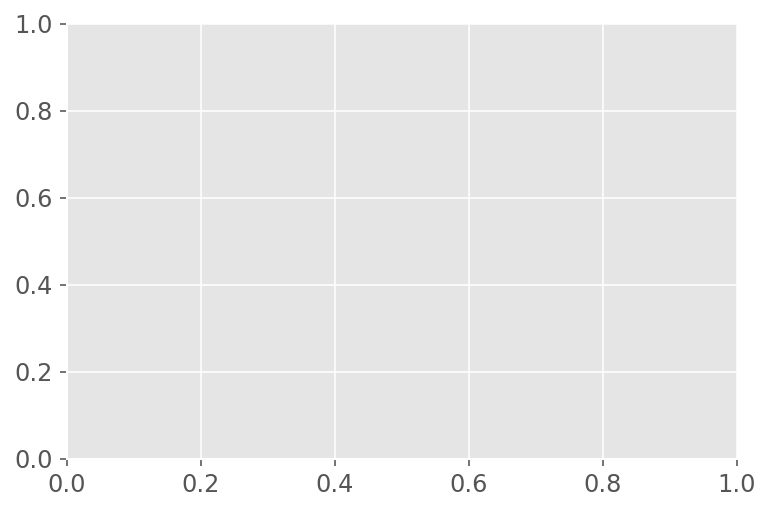

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
df.total_spend.value_counts().plot(kind = "bar", bins = 6)

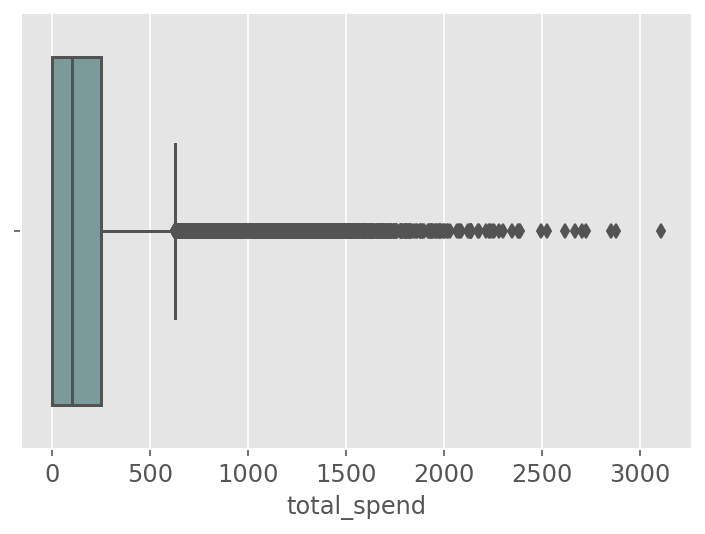

In [9]:
sns.boxplot(x=df['total_spend'])

### Missing data - checking for nulls

In [21]:
df.isnull().sum()

user_id             0
assignment_date     0
express             0
loyalty             0
zip_code            0
address_type        0
experiment_group    0
grp_code            0
orders_placed       0
avg_order_value     0
total_spend         0
dtype: int64

### What about outliers?

In [83]:
df.total_spend.max()

3104.46

In [84]:
df.orders_placed.max()

13

I think those are both within the realm of believability, so we'll leave the data as is

# Questions/Analysis

## 1. What can we learn from these results?

### Before diving into experimental results, it would behoove us to perform some balance checks between the buckets

In [5]:
# residential vs business

In [23]:
df.groupby(["grp_code", "address_type"]).size()

grp_code  address_type
c0        Business         3987
          Residential     45728
v1        Business         2039
          Residential     23095
v2        Business         1974
          Residential     23177
dtype: int64

In [35]:
grps = ['c0', 'v1', 'v2']
for grp in grps:
    print("The percent of orders to a residence for group "+str(grp)+" is "+str(100*len(df[(df['grp_code'] == grp) & (df['address_type'] == 'Residential')]) / len(df[df['grp_code'] == grp]))+"%")

The percent of orders to a residence for group c0 is 91.98028763954541%
The percent of orders to a residence for group v1 is 91.8874830906342%
The percent of orders to a residence for group v2 is 92.15140551071528%


In [25]:
# express vs loyalty

In [36]:
for grp in grps:
    print("The percent of orders by Express members in group "+str(grp)+" is "+str(100*len(df[(df['grp_code'] == grp) & (df['express'] == 1)]) / len(df[df['grp_code'] == grp]))+"%")

The percent of orders by Express members in group c0 is 49.109926581514635%
The percent of orders by Express members in group v1 is 49.35147608816742%
The percent of orders by Express members in group v2 is 49.91451632141863%


In [37]:
for grp in grps:
    print("The percent of orders by Loyalty members in group "+str(grp)+" is "+str(100*len(df[(df['grp_code'] == grp) & (df['loyalty'] == 1)]) / len(df[df['grp_code'] == grp]))+"%")

The percent of orders by Loyalty members in group c0 is 16.994870763351102%
The percent of orders by Loyalty members in group v1 is 16.817856290284077%
The percent of orders by Loyalty members in group v2 is 17.235895193034075%


In [6]:
# unique zipcodes 

In [94]:
df.groupby('grp_code').zip_code.nunique()

grp_code
c0    22
v1    22
v2    22
Name: zip_code, dtype: int64

Observing each breakdown variable across groups, we appear to have pretty well-balanced sampling popultations at a fundamental level, which lends an air of reliability to the results of the experiment, and confirms our implicit assumptions of truly random assignment required for proper A/B/C testing

#### Adjusting our target metric

Assuming the experiment has run up until today, it would be useful to have a variable for the amount of time that someone was in the experiment (otherwise comparing total spend between customers won't be apples to apples)

In [4]:
df['assignment_date'] = pd.to_datetime(df['assignment_date'], format='%Y-%m-%d')
df['time_in_experiment'] = pd.to_datetime("now") - df['assignment_date']
df['time_in_experiment'] = pd.to_numeric(df['time_in_experiment'].dt.days, downcast='integer')

In [32]:
# average time in experiment per group to make sure we're balanced
df.groupby('grp_code').time_in_experiment.mean()

grp_code
c0    106.502323
v1    106.449908
v2    106.598863
Name: time_in_experiment, dtype: float64

Fortunately, time spent in our experiment is well-balanced between the buckets. However, as a principle of good practice, it's useful to index topline metrics with a denominator.
More speficially, dividing our primary concern (total spending) by time (days in the experiment, in this case) gives us spend per day

In [7]:
df['spend_per_day'] = df['total_spend'] / df['time_in_experiment']

### Initial results

Glancing at basic distribution stats for our new metric by bucket

In [33]:
conversion_rates = df.groupby('grp_code')['spend_per_day']

std_p = lambda x: np.std(x, ddof=0)    
se_p = lambda x: stats.sem(x, ddof=0)  

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['spend_per_day', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,spend_per_day,std_deviation,std_error
grp_code,,,
c0,1.538,2.067,0.009
v1,1.569,2.060,0.013
v2,1.679,2.083,0.013


Our first look at the key results: percent difference in spend per day by bucket

Control vs Variant 1 isolates the effect of our new virtual convenience store experience

Control vs Variant 2 has multiple axes of change, so is only helpful for understanding the total impact of a set of altered features - still, this is a reasonably possible course of action, so we should look at the delta

In [34]:
tests = ['v1', 'v2']
for test in tests:
    "The percent improvement of the "+test+" group over the control group in spend per day was "+str(100*(df[df['grp_code'] == test].spend_per_day.mean() - df[df['grp_code'] == 'c0'].spend_per_day.mean()) / df[df['grp_code'] == 'c0'].spend_per_day.mean())+"%"

'The percent improvement of the v1 group over the control group in spend per day was 2.0155681056879007%'

'The percent improvement of the v2 group over the control group in spend per day was 9.182581240253429%'

Variant 1 to variant 2 isolates the effect of a lower cart total minimum (in the virtual convenience environment whether that would translate elsewhere is a somewhat separate question), so we can see the impact on daily spending that that change had by comparing those buckets

In [35]:
"The percent improvement of the v2 group over the v1 group in spend per day was "+str(100*(df[df['grp_code'] == 'v2'].spend_per_day.mean() - df[df['grp_code'] == 'v1'].spend_per_day.mean()) / df[df['grp_code'] == 'v1'].spend_per_day.mean())+"%"

'The percent improvement of the v2 group over the v1 group in spend per day was 7.025411187379281%'

### Secondary-level questions

Any negative externalities? (counter metrics)

In [85]:
# examining the average number of orders placed by bucket
df.groupby('grp_code').orders_placed.mean()

grp_code
c0    1.378759
v1    1.448397
v2    1.710111
Name: orders_placed, dtype: float64

In [87]:
# examining the average order value by bucket
df.groupby('grp_code').avg_order_value.mean()

grp_code
c0    78.806962
v1    78.344144
v2    76.503307
Name: avg_order_value, dtype: float64

Hmmm, while increasing the number of orders placed per [unit of time] is generally good, here there seems to have been a commensurate offset between that increase, and a reduction in the average order size.

More orders, with a lower cart total, means worse (order-level) unit economics

#### In sum

At a glance, it our appears our tests were pretty succesful, and we should be able to reject the null hypothesis, implement our changes, and declare victory!

But wait....what if those results were spurious? How do we know the differences didn't just occur by chance?

## 2. How do we assess the reliability of these findings?

### Statistical significance testing

#### Student t-testing

In [14]:
# control vs V1
a = df.loc[df['grp_code'] == 'c0', 'spend_per_day'].to_numpy()
b = df.loc[df['grp_code'] == 'v1', 'spend_per_day'].to_numpy()
stats.ttest_ind(a=a, b=b, equal_var=True)

Ttest_indResult(statistic=-1.9379260492168127, pvalue=0.05263600147443164)

In [101]:
# V1 vs V2
a = df.loc[df['grp_code'] == 'v1', 'spend_per_day'].to_numpy()
b = df.loc[df['grp_code'] == 'v2', 'spend_per_day'].to_numpy()
stats.ttest_ind(a=a, b=b, equal_var=True)

Ttest_indResult(statistic=-5.963002621211004, pvalue=2.492924084862043e-09)

In [15]:
# c0 vs V2
a = df.loc[df['grp_code'] == 'c0', 'spend_per_day'].to_numpy()
b = df.loc[df['grp_code'] == 'v2', 'spend_per_day'].to_numpy()
stats.ttest_ind(a=a, b=b, equal_var=True)

Ttest_indResult(statistic=-8.803087730623057, pvalue=1.3586662638317834e-18)

#### z testing

In [33]:
control = df[(df['grp_code'] == 'c0')].spend_per_day

variant1 = df[(df['grp_code'] == 'v1')].spend_per_day

#perform two sample z-test
ztest(control, variant1, value=0) 

(-1.9379260492168127, 0.05263224537285123)

In [34]:
control = df[(df['grp_code'] == 'v1')].spend_per_day

variant1 = df[(df['grp_code'] == 'v2')].spend_per_day

#perform two sample z-test
ztest(control, variant1, value=0) 

(-5.9627544621878545, 2.4802097854330537e-09)

#### BEST section

##### Control vs Variant 1

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [nu-1]
>Metropolis: [std_B]
>Metropolis: [std_A]
>Metropolis: [mu_B]
>Metropolis: [mu_A]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 57 seconds.
The number of effective samples is smaller than 10% for some parameters.


(array([  5.,  21.,  29.,  59.,  92.,  51.,  68.,  94., 184., 148., 199.,
        184., 385., 267., 276., 355., 435., 300., 430., 347., 393., 282.,
        288., 232., 122., 143., 145., 147., 108.,  59.,  56.,  53.,   7.,
         30.,   1.,   0.,   0.,   0.,   0.,   5.]),
 array([0.83796043, 0.8391141 , 0.84026778, 0.84142145, 0.84257513,
        0.84372881, 0.84488248, 0.84603616, 0.84718983, 0.84834351,
        0.84949719, 0.85065086, 0.85180454, 0.85295821, 0.85411189,
        0.85526557, 0.85641924, 0.85757292, 0.85872659, 0.85988027,
        0.86103395, 0.86218762, 0.8633413 , 0.86449497, 0.86564865,
        0.86680233, 0.867956  , 0.86910968, 0.87026335, 0.87141703,
        0.87257071, 0.87372438, 0.87487806, 0.87603173, 0.87718541,
        0.87833909, 0.87949276, 0.88064644, 0.88180011, 0.88295379,
        0.88410747]),
 <a list of 40 Patch objects>)

(array([  2.,   4.,   9.,   3.,  24.,   6.,  29.,  14.,  69., 107.,  67.,
        172., 164., 179., 289., 281., 286., 245., 329., 444., 504., 430.,
        430., 234., 354., 320., 211., 209., 116., 108.,  86., 114.,  64.,
         29.,  22.,  11.,  11.,   3.,  16.,   5.]),
 array([0.8615509 , 0.86315151, 0.86475211, 0.86635272, 0.86795333,
        0.86955393, 0.87115454, 0.87275514, 0.87435575, 0.87595636,
        0.87755696, 0.87915757, 0.88075817, 0.88235878, 0.88395938,
        0.88555999, 0.8871606 , 0.8887612 , 0.89036181, 0.89196241,
        0.89356302, 0.89516363, 0.89676423, 0.89836484, 0.89996544,
        0.90156605, 0.90316666, 0.90476726, 0.90636787, 0.90796847,
        0.90956908, 0.91116969, 0.91277029, 0.9143709 , 0.9159715 ,
        0.91757211, 0.91917271, 0.92077332, 0.92237393, 0.92397453,
        0.92557514]),
 <a list of 40 Patch objects>)

Text(0.5, 1.0, 'Posterior distributions for each respective group mean')

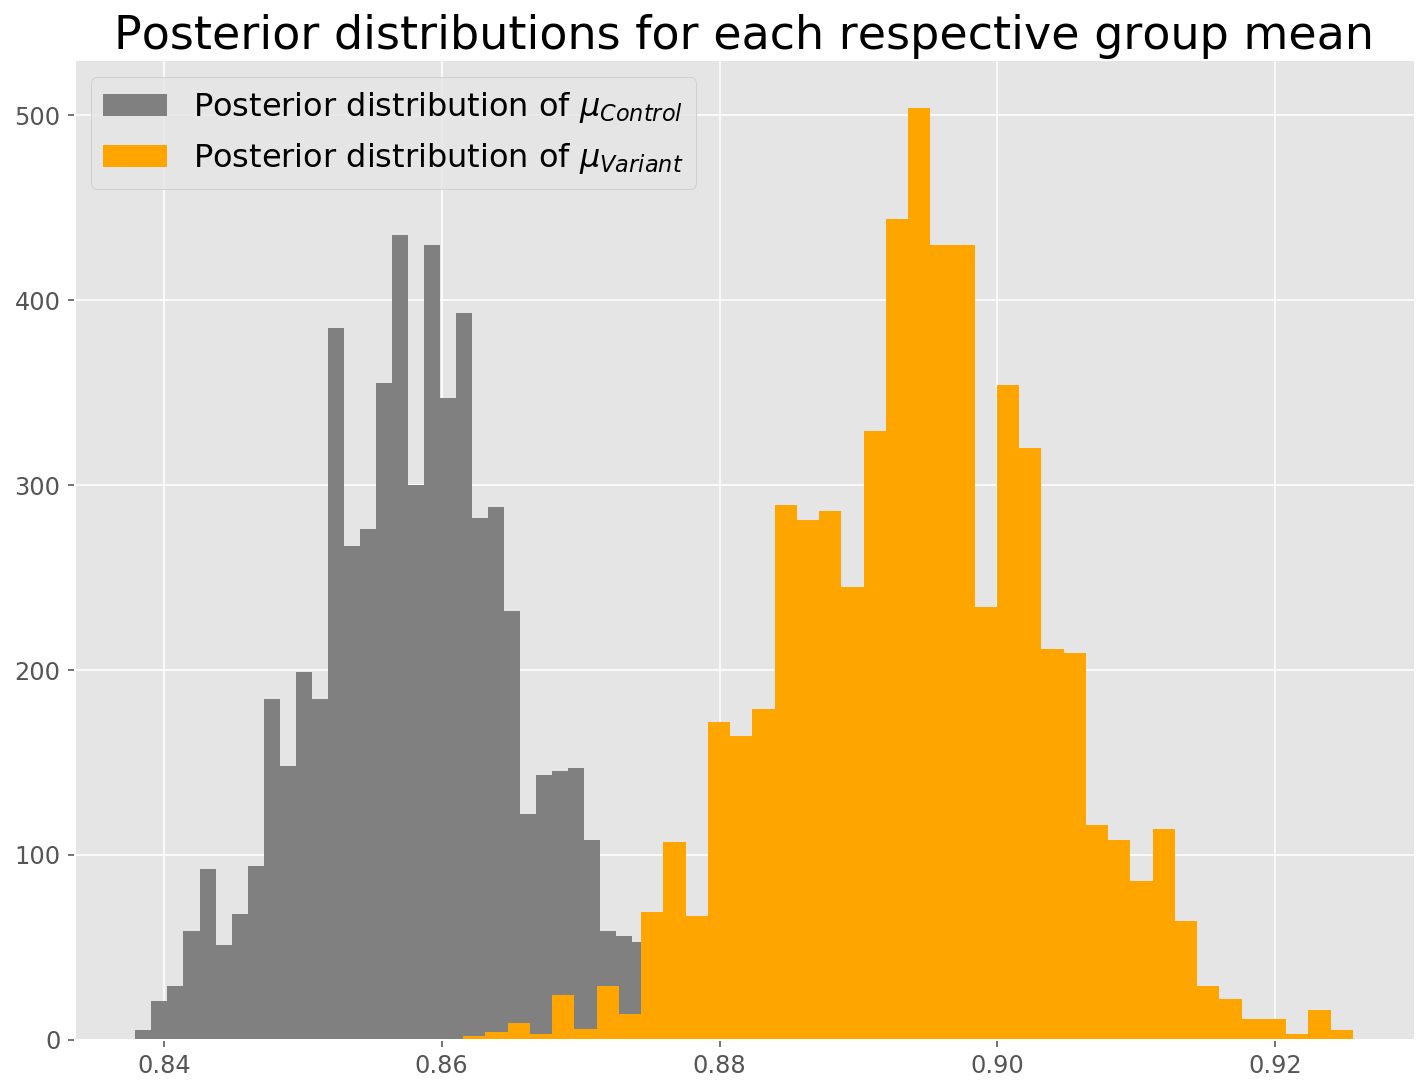

In [48]:
control = df[(df['grp_code'] == 'c0')]
variant = df[(df['grp_code'] == 'v1')]
# Setting pooled mean and standard deviation and degrees of freedom parameters:

pooled_mean = np.r_[control.spend_per_day, variant.spend_per_day].mean()
pooled_std = np.r_[control.spend_per_day, variant.spend_per_day].std()
variance = 2 * pooled_std
with pm.Model() as model_1:
    mu_A = pm.Normal("mu_A", pooled_mean, sd = variance)
    mu_B = pm.Normal("mu_B", pooled_mean, sd = variance)
    std_A = pm.Uniform("std_A", 1/100, 100)
    std_B = pm.Uniform("std_B", 1/100, 100)
    nu_minus_1 = pm.Exponential("nu-1", 1.0/29)
    
# running the MCMC simulations to calculate a series of posterior distributions:

with model_1:
    obs_A = pm.StudentT("obs_A", mu = mu_A, lam = 1.0/std_A**2, nu = nu_minus_1+1, observed=control.spend_per_day)
    obs_B = pm.StudentT("obs_B", mu = mu_B, lam = 1.0/std_B**2, nu=nu_minus_1+1, observed=variant.spend_per_day)
    start = pm.find_MAP()
    step = pm.Metropolis(vars =[mu_A, mu_B, std_A, std_B, nu_minus_1])
    trace_1 = pm.sample(2500, step = step)
    burned_trace_1 = trace_1[1000:]
# Visualizing the posterior distribution of the group means:


control_mean = burned_trace_1['mu_A']
variant_mean = burned_trace_1['mu_B']
plt.hist(control_mean, bins = 40, label=r'Posterior distribution of $\mu_{Control}$', color = 'grey')
plt.hist(variant_mean, bins = 40, label=r'Posterior distribution of $\mu_{Variant}$', color = 'orange')
plt.title('Posterior distributions for each respective group mean')
plt.legend()
plt.show()

(array([  5.,  21.,  29.,  59.,  92.,  51.,  68.,  94., 184., 148., 199.,
        184., 385., 267., 276., 355., 435., 300., 430., 347., 393., 282.,
        288., 232., 122., 143., 145., 147., 108.,  59.,  56.,  53.,   7.,
         30.,   1.,   0.,   0.,   0.,   0.,   5.]),
 array([0.83796043, 0.8391141 , 0.84026778, 0.84142145, 0.84257513,
        0.84372881, 0.84488248, 0.84603616, 0.84718983, 0.84834351,
        0.84949719, 0.85065086, 0.85180454, 0.85295821, 0.85411189,
        0.85526557, 0.85641924, 0.85757292, 0.85872659, 0.85988027,
        0.86103395, 0.86218762, 0.8633413 , 0.86449497, 0.86564865,
        0.86680233, 0.867956  , 0.86910968, 0.87026335, 0.87141703,
        0.87257071, 0.87372438, 0.87487806, 0.87603173, 0.87718541,
        0.87833909, 0.87949276, 0.88064644, 0.88180011, 0.88295379,
        0.88410747]),
 <a list of 40 Patch objects>)

(array([  2.,   4.,   9.,   3.,  24.,   6.,  29.,  14.,  69., 107.,  67.,
        172., 164., 179., 289., 281., 286., 245., 329., 444., 504., 430.,
        430., 234., 354., 320., 211., 209., 116., 108.,  86., 114.,  64.,
         29.,  22.,  11.,  11.,   3.,  16.,   5.]),
 array([0.8615509 , 0.86315151, 0.86475211, 0.86635272, 0.86795333,
        0.86955393, 0.87115454, 0.87275514, 0.87435575, 0.87595636,
        0.87755696, 0.87915757, 0.88075817, 0.88235878, 0.88395938,
        0.88555999, 0.8871606 , 0.8887612 , 0.89036181, 0.89196241,
        0.89356302, 0.89516363, 0.89676423, 0.89836484, 0.89996544,
        0.90156605, 0.90316666, 0.90476726, 0.90636787, 0.90796847,
        0.90956908, 0.91116969, 0.91277029, 0.9143709 , 0.9159715 ,
        0.91757211, 0.91917271, 0.92077332, 0.92237393, 0.92397453,
        0.92557514]),
 <a list of 40 Patch objects>)

Text(0.5, 1.0, 'Posterior distributions of standard derivation derived from PyMC3')

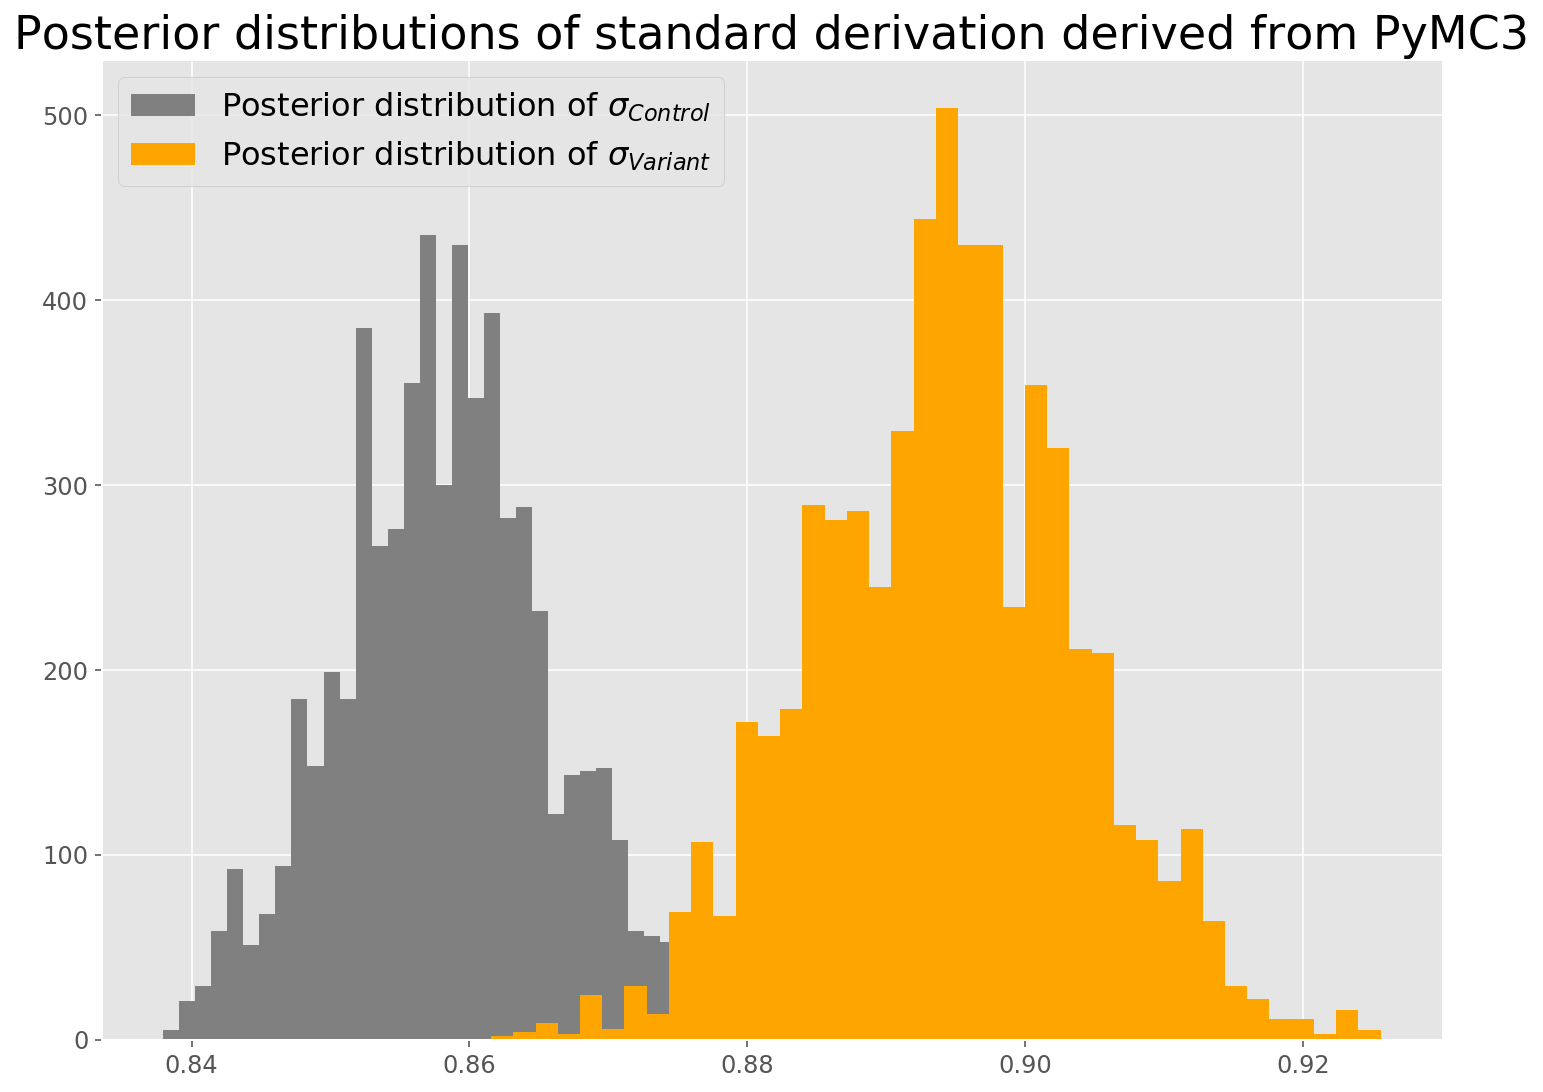

In [49]:
control_std = burned_trace_1['mu_A']
variant_std = burned_trace_1['mu_B']
plt.hist(control_std, bins = 40, label=r'Posterior distribution of $\sigma_{Control}$', color = 'grey')
plt.hist(variant_std, bins = 40, label=r'Posterior distribution of $\sigma_{Variant}$', color = 'orange')
plt.title('Posterior distributions of standard derivation derived from PyMC3')
plt.legend()
plt.show()

(array([ 0.11224462,  0.        ,  0.44897849,  0.89795697,  0.67346773,
         0.56122311,  1.57142471,  2.69387092,  4.04080639,  7.29590042,
         5.05100798,  7.29590042, 10.21426059, 10.88772832, 15.04077933,
        15.48975781, 17.06118252, 15.71424706, 27.83666622, 20.98974428,
        26.26524151, 22.67341361, 35.4693005 , 34.79583277, 35.69378975,
        28.06115546, 30.97951563, 38.16317143, 36.14276823, 35.24481126,
        42.31622244, 29.40809092, 13.35711   , 22.33667975, 20.76525504,
        12.68364227, 11.22446218,  9.65303748,  6.39794345,  4.6020295 ,
         3.81631714,  3.03060479,  1.68366933,  1.79591395,  0.67346773,
         1.23469084,  0.22448924,  0.33673387,  0.33673387,  0.22448924]),
 array([-0.00131686,  0.00016799,  0.00165285,  0.0031377 ,  0.00462255,
         0.0061074 ,  0.00759225,  0.00907711,  0.01056196,  0.01204681,
         0.01353166,  0.01501652,  0.01650137,  0.01798622,  0.01947107,
         0.02095592,  0.02244078,  0.02392563,  0

Text(0.5, 1.0, 'Posterior distribution of the the difference of the means')

Text(0.5, 1.0, 'Posterior distribution of the the difference of mean for Metric 1')

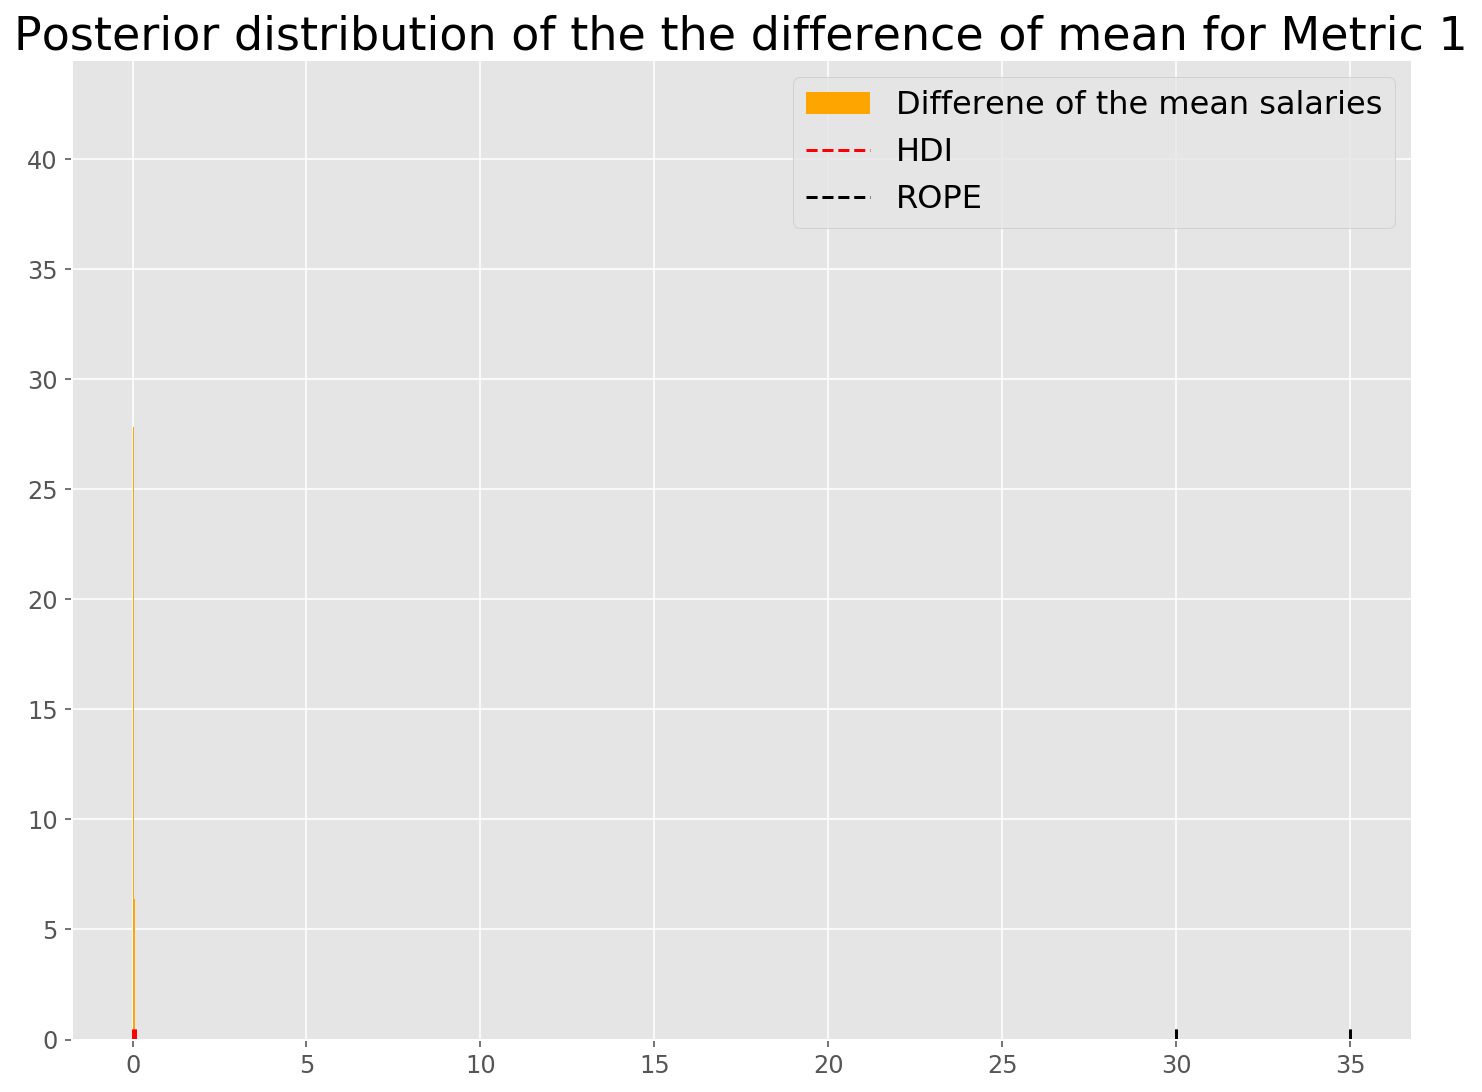

In [62]:
import arviz as az

difference = variant_mean - control_mean # Difference of the means
# hdi = pm.stats.hpd(difference, hdi_prob = 0.95) # The 95% HDI interval of the difference
hdi = az.hdi(difference, hdi_prob=0.95)
rope = [30,35] #the ROPE region
plt.hist(difference, bins=50, density=True, label='Differene of the mean salaries', color = 'orange')
plt.title('Posterior distribution of the the difference of the means')
plt.vlines(hdi[0], 0,0.6, linestyle='--', color='red', label='HDI')
plt.vlines(hdi[1], 0, 0.6, linestyle='--', color='red')
plt.vlines(rope[0], 0, 0.6, linestyle='--', color='black', label='ROPE')
plt.vlines(rope[1], 0, 0.6, linestyle='--', color='black')
plt.title('Posterior distribution of the the difference of mean for Metric 1')
plt.legend(loc='upper right')
plt.show()

In [63]:
difference = variant_mean - control_mean # Difference of the means
hdi = pm.stats.hpd(difference, hdi_prob = 0.95) # The 95% HDI interval of the difference
rope = [30,35] #the ROPE region
plt.hist(difference, bins=50, density=True, label='Differene of the mean salaries', color = 'orange')
plt.title('Posterior distribution of the the difference of the means')
plt.vlines(hdi[0], 0,0.6, linestyle='--', color='red', label='HDI')
plt.vlines(hdi[1], 0, 0.6, linestyle='--', color='red')
plt.vlines(rope[0], 0, 0.6, linestyle='--', color='black', label='ROPE')
plt.vlines(rope[1], 0, 0.6, linestyle='--', color='black')
plt.title('Posterior distribution of the the difference of mean for Metric 1')
plt.legend(loc='upper right')
plt.show()

AttributeError: module 'pymc3.stats' has no attribute 'hpd'

(array([0.00103334, 0.        , 0.00413335, 0.00620002, 0.0082667 ,
        0.00103334, 0.00723336, 0.02686676, 0.02066674, 0.05786687,
        0.05683353, 0.04236681, 0.08990031, 0.08990031, 0.10230035,
        0.14053382, 0.15500054, 0.14776718, 0.17463394, 0.2604009 ,
        0.18910066, 0.20976739, 0.27073427, 0.28416765, 0.33686783,
        0.32240112, 0.22836746, 0.29760103, 0.36373459, 0.36270126,
        0.34306786, 0.34306786, 0.23870083, 0.16120056, 0.17256727,
        0.17876729, 0.12090042, 0.1260671 , 0.06406689, 0.05270018,
        0.02893343, 0.04133348, 0.0196334 , 0.01860006, 0.01033337,
        0.00723336, 0.00620002, 0.00206667, 0.00413335, 0.00206667]),
 array([-0.1522299 ,  0.00905987,  0.17034963,  0.33163939,  0.49292916,
         0.65421892,  0.81550868,  0.97679845,  1.13808821,  1.29937797,
         1.46066774,  1.6219575 ,  1.78324726,  1.94453703,  2.10582679,
         2.26711655,  2.42840632,  2.58969608,  2.75098584,  2.91227561,
         3.07356537,  3.23

Text(0.5, 1.0, 'Posterior distribution of the the relative difference of mean values')

The probability that the variant performed 2% greater than the control is: 94.4%


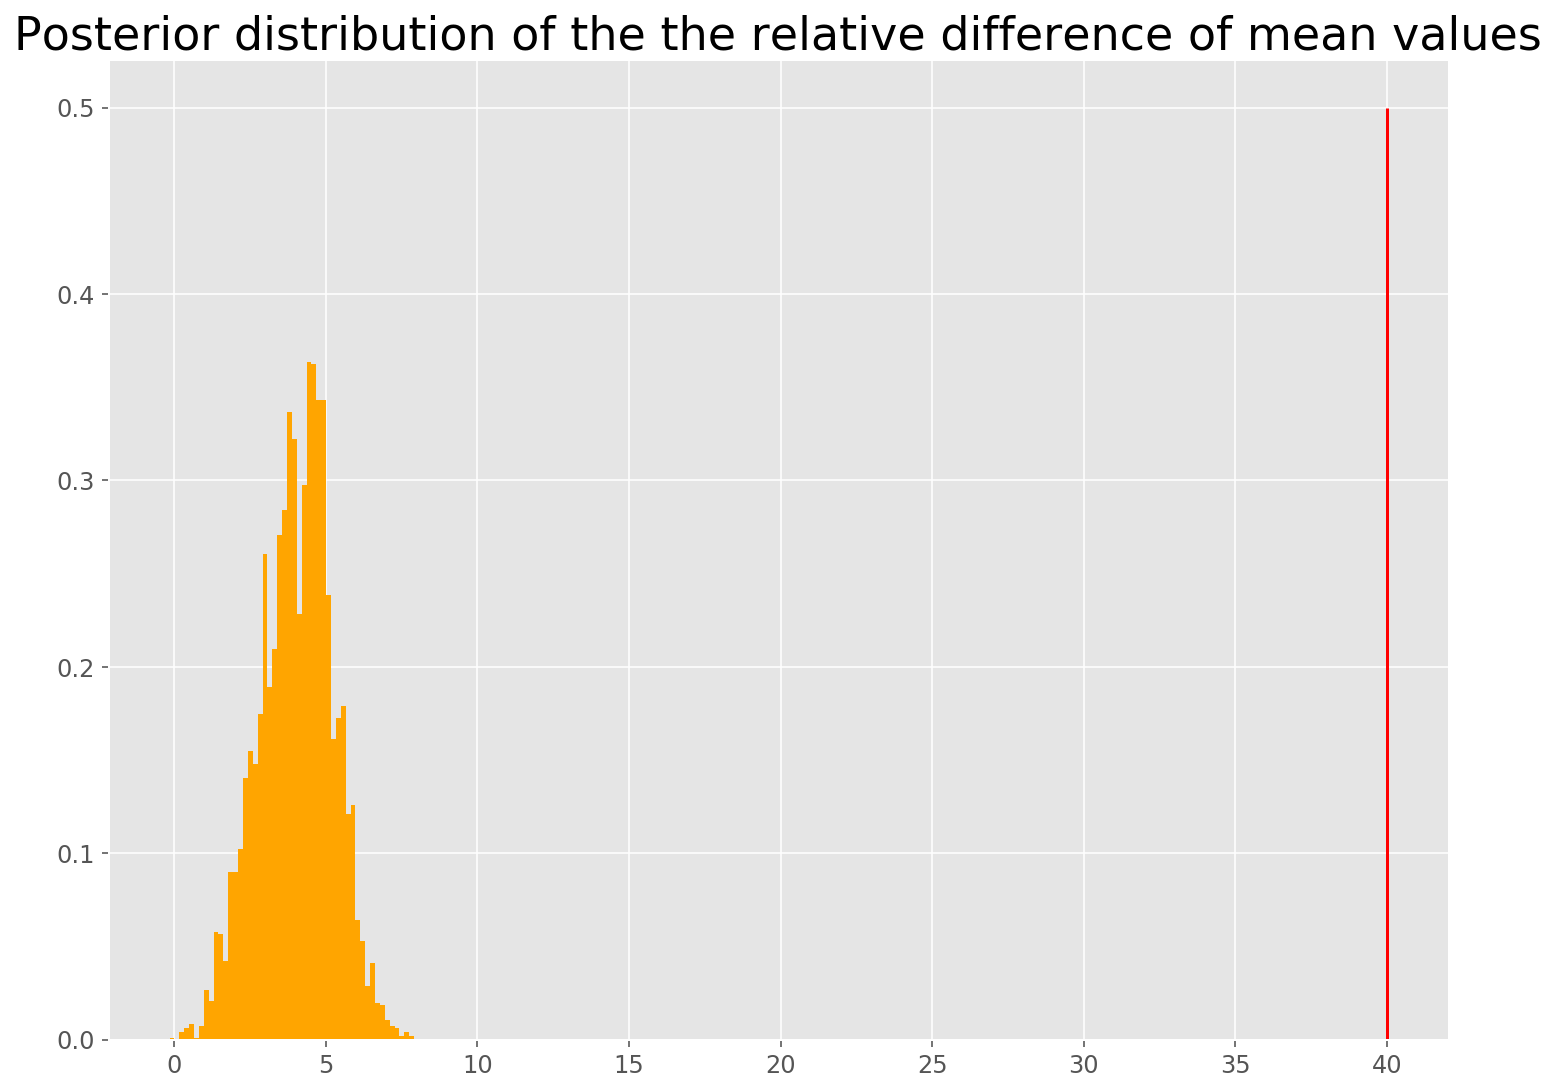

In [67]:
rel_difference = 100 * (variant_mean-control_mean)/variant_mean
prob = len(rel_difference[rel_difference > 2])/len(rel_difference)
plt.hist(rel_difference, bins=50, density=True, label='Relative differene of the mean metric', color = 'orange')
plt.title('Posterior distribution of the the relative difference of mean values')
plt.vlines(40, 0,0.5, linestyle='-', color='red', label='HDI')
print(f"The probability that the variant performed 2% greater than the control is: {round(prob*100,2)}%")
plt.show()

##### Variant 1 vs Variant 2

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [nu-1]
>Metropolis: [std_B]
>Metropolis: [std_A]
>Metropolis: [mu_B]
>Metropolis: [mu_A]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 46 seconds.
The number of effective samples is smaller than 10% for some parameters.


(array([  6.,   5.,   2.,  21.,   0.,  18.,  98.,  62., 127.,  89., 147.,
        198., 253., 238., 379., 475., 441., 509., 489., 333., 264., 263.,
        383., 271., 241., 228., 114.,  76., 138.,  56.,  25.,  13.,  15.,
          6.,   2.,   1.,   8.,   0.,   0.,   6.]),
 array([0.88604092, 0.88778482, 0.88952871, 0.89127261, 0.8930165 ,
        0.8947604 , 0.89650429, 0.89824819, 0.89999208, 0.90173598,
        0.90347987, 0.90522377, 0.90696766, 0.90871155, 0.91045545,
        0.91219934, 0.91394324, 0.91568713, 0.91743103, 0.91917492,
        0.92091882, 0.92266271, 0.92440661, 0.9261505 , 0.9278944 ,
        0.92963829, 0.93138219, 0.93312608, 0.93486998, 0.93661387,
        0.93835777, 0.94010166, 0.94184555, 0.94358945, 0.94533334,
        0.94707724, 0.94882113, 0.95056503, 0.95230892, 0.95405282,
        0.95579671]),
 <a list of 40 Patch objects>)

(array([  6.,   0.,   0.,   6.,   8.,  27.,  14.,  61.,  31.,  37.,  67.,
        119., 184., 163., 316., 349., 433., 360., 375., 437., 377., 301.,
        338., 269., 399., 341., 243., 159., 166., 120.,  78.,  91.,  57.,
         14.,  22.,   9.,  16.,   4.,   0.,   3.]),
 array([1.01138252, 1.01317594, 1.01496937, 1.0167628 , 1.01855623,
        1.02034966, 1.02214309, 1.02393651, 1.02572994, 1.02752337,
        1.0293168 , 1.03111023, 1.03290365, 1.03469708, 1.03649051,
        1.03828394, 1.04007737, 1.0418708 , 1.04366422, 1.04545765,
        1.04725108, 1.04904451, 1.05083794, 1.05263137, 1.05442479,
        1.05621822, 1.05801165, 1.05980508, 1.06159851, 1.06339194,
        1.06518536, 1.06697879, 1.06877222, 1.07056565, 1.07235908,
        1.0741525 , 1.07594593, 1.07773936, 1.07953279, 1.08132622,
        1.08311965]),
 <a list of 40 Patch objects>)

Text(0.5, 1.0, 'Posterior distributions for each respective group mean')

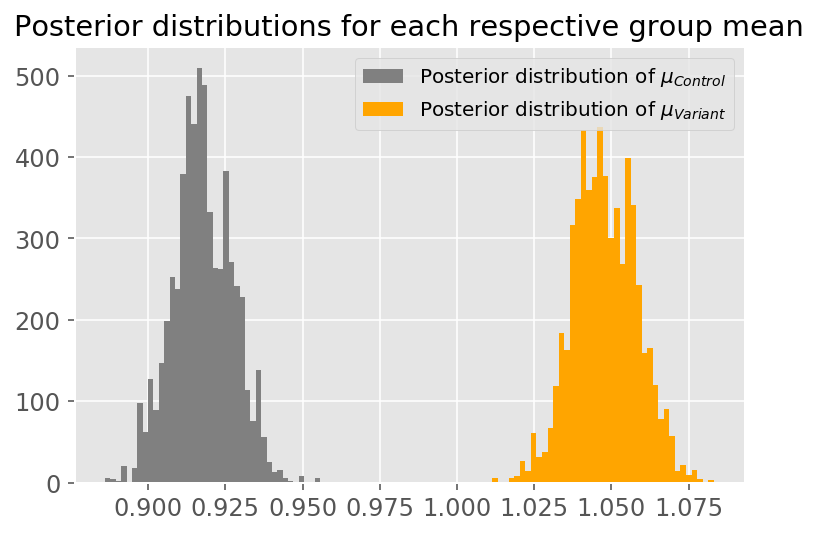

In [81]:
control = df[(df['grp_code'] == 'v1')]
variant = df[(df['grp_code'] == 'v2')]

pooled_mean = np.r_[control.spend_per_day, variant.spend_per_day].mean()
pooled_std = np.r_[control.spend_per_day, variant.spend_per_day].std()
variance = 2 * pooled_std
with pm.Model() as model_1:
    mu_A = pm.Normal("mu_A", pooled_mean, sd = variance)
    mu_B = pm.Normal("mu_B", pooled_mean, sd = variance)
    std_A = pm.Uniform("std_A", 1/100, 100)
    std_B = pm.Uniform("std_B", 1/100, 100)
    nu_minus_1 = pm.Exponential("nu-1", 1.0/29)

with model_1:
    obs_A = pm.StudentT("obs_A", mu = mu_A, lam = 1.0/std_A**2, nu = nu_minus_1+1, observed=control.spend_per_day)
    obs_B = pm.StudentT("obs_B", mu = mu_B, lam = 1.0/std_B**2, nu=nu_minus_1+1, observed=variant.spend_per_day)
    start = pm.find_MAP()
    step = pm.Metropolis(vars =[mu_A, mu_B, std_A, std_B, nu_minus_1])
    trace_1 = pm.sample(2500, step = step)
    burned_trace_1 = trace_1[1000:]


control_mean = burned_trace_1['mu_A']
variant_mean = burned_trace_1['mu_B']
plt.hist(control_mean, bins = 40, label=r'Posterior distribution of $\mu_{Control}$', color = 'grey')
plt.hist(variant_mean, bins = 40, label=r'Posterior distribution of $\mu_{Variant}$', color = 'orange')
plt.title('Posterior distributions for each respective group mean')
plt.legend()
plt.show()

(array([  6.,   5.,   2.,  21.,   0.,  18.,  98.,  62., 127.,  89., 147.,
        198., 253., 238., 379., 475., 441., 509., 489., 333., 264., 263.,
        383., 271., 241., 228., 114.,  76., 138.,  56.,  25.,  13.,  15.,
          6.,   2.,   1.,   8.,   0.,   0.,   6.]),
 array([0.88604092, 0.88778482, 0.88952871, 0.89127261, 0.8930165 ,
        0.8947604 , 0.89650429, 0.89824819, 0.89999208, 0.90173598,
        0.90347987, 0.90522377, 0.90696766, 0.90871155, 0.91045545,
        0.91219934, 0.91394324, 0.91568713, 0.91743103, 0.91917492,
        0.92091882, 0.92266271, 0.92440661, 0.9261505 , 0.9278944 ,
        0.92963829, 0.93138219, 0.93312608, 0.93486998, 0.93661387,
        0.93835777, 0.94010166, 0.94184555, 0.94358945, 0.94533334,
        0.94707724, 0.94882113, 0.95056503, 0.95230892, 0.95405282,
        0.95579671]),
 <a list of 40 Patch objects>)

(array([  6.,   0.,   0.,   6.,   8.,  27.,  14.,  61.,  31.,  37.,  67.,
        119., 184., 163., 316., 349., 433., 360., 375., 437., 377., 301.,
        338., 269., 399., 341., 243., 159., 166., 120.,  78.,  91.,  57.,
         14.,  22.,   9.,  16.,   4.,   0.,   3.]),
 array([1.01138252, 1.01317594, 1.01496937, 1.0167628 , 1.01855623,
        1.02034966, 1.02214309, 1.02393651, 1.02572994, 1.02752337,
        1.0293168 , 1.03111023, 1.03290365, 1.03469708, 1.03649051,
        1.03828394, 1.04007737, 1.0418708 , 1.04366422, 1.04545765,
        1.04725108, 1.04904451, 1.05083794, 1.05263137, 1.05442479,
        1.05621822, 1.05801165, 1.05980508, 1.06159851, 1.06339194,
        1.06518536, 1.06697879, 1.06877222, 1.07056565, 1.07235908,
        1.0741525 , 1.07594593, 1.07773936, 1.07953279, 1.08132622,
        1.08311965]),
 <a list of 40 Patch objects>)

Text(0.5, 1.0, 'Posterior distributions of standard derivation derived from PyMC3')

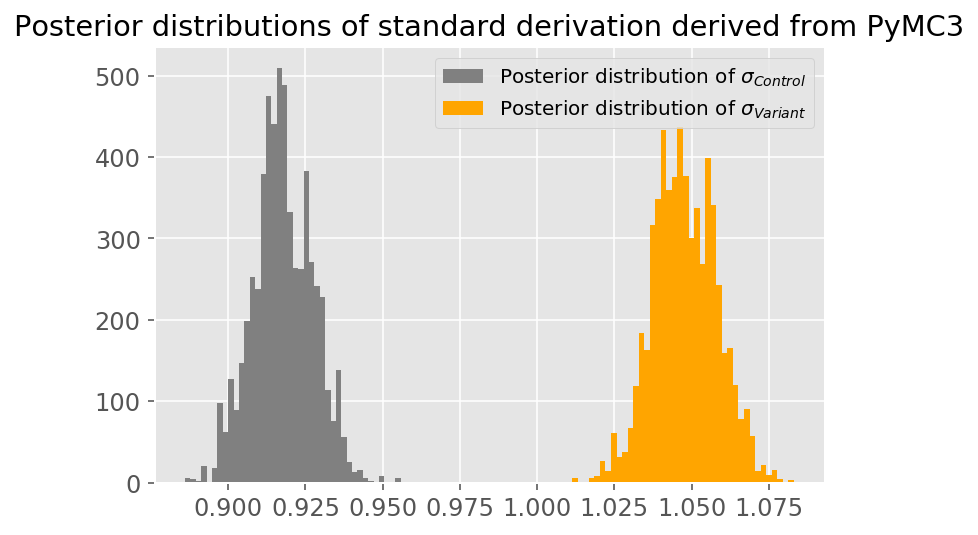

In [82]:
control_std = burned_trace_1['mu_A']
variant_std = burned_trace_1['mu_B']
plt.hist(control_std, bins = 40, label=r'Posterior distribution of $\sigma_{Control}$', color = 'grey')
plt.hist(variant_std, bins = 40, label=r'Posterior distribution of $\sigma_{Variant}$', color = 'orange')
plt.title('Posterior distributions of standard derivation derived from PyMC3')
plt.legend()
plt.show()

(array([0.00103334, 0.        , 0.00413335, 0.00620002, 0.0082667 ,
        0.00103334, 0.00723336, 0.02686676, 0.02066674, 0.05786687,
        0.05683353, 0.04236681, 0.08990031, 0.08990031, 0.10230035,
        0.14053382, 0.15500054, 0.14776718, 0.17463394, 0.2604009 ,
        0.18910066, 0.20976739, 0.27073427, 0.28416765, 0.33686783,
        0.32240112, 0.22836746, 0.29760103, 0.36373459, 0.36270126,
        0.34306786, 0.34306786, 0.23870083, 0.16120056, 0.17256727,
        0.17876729, 0.12090042, 0.1260671 , 0.06406689, 0.05270018,
        0.02893343, 0.04133348, 0.0196334 , 0.01860006, 0.01033337,
        0.00723336, 0.00620002, 0.00206667, 0.00413335, 0.00206667]),
 array([-0.1522299 ,  0.00905987,  0.17034963,  0.33163939,  0.49292916,
         0.65421892,  0.81550868,  0.97679845,  1.13808821,  1.29937797,
         1.46066774,  1.6219575 ,  1.78324726,  1.94453703,  2.10582679,
         2.26711655,  2.42840632,  2.58969608,  2.75098584,  2.91227561,
         3.07356537,  3.23

Text(0.5, 1.0, 'Posterior distribution of the the relative difference of mean values')

The probability that the variant performed 10% greater than the control is: 0.0%


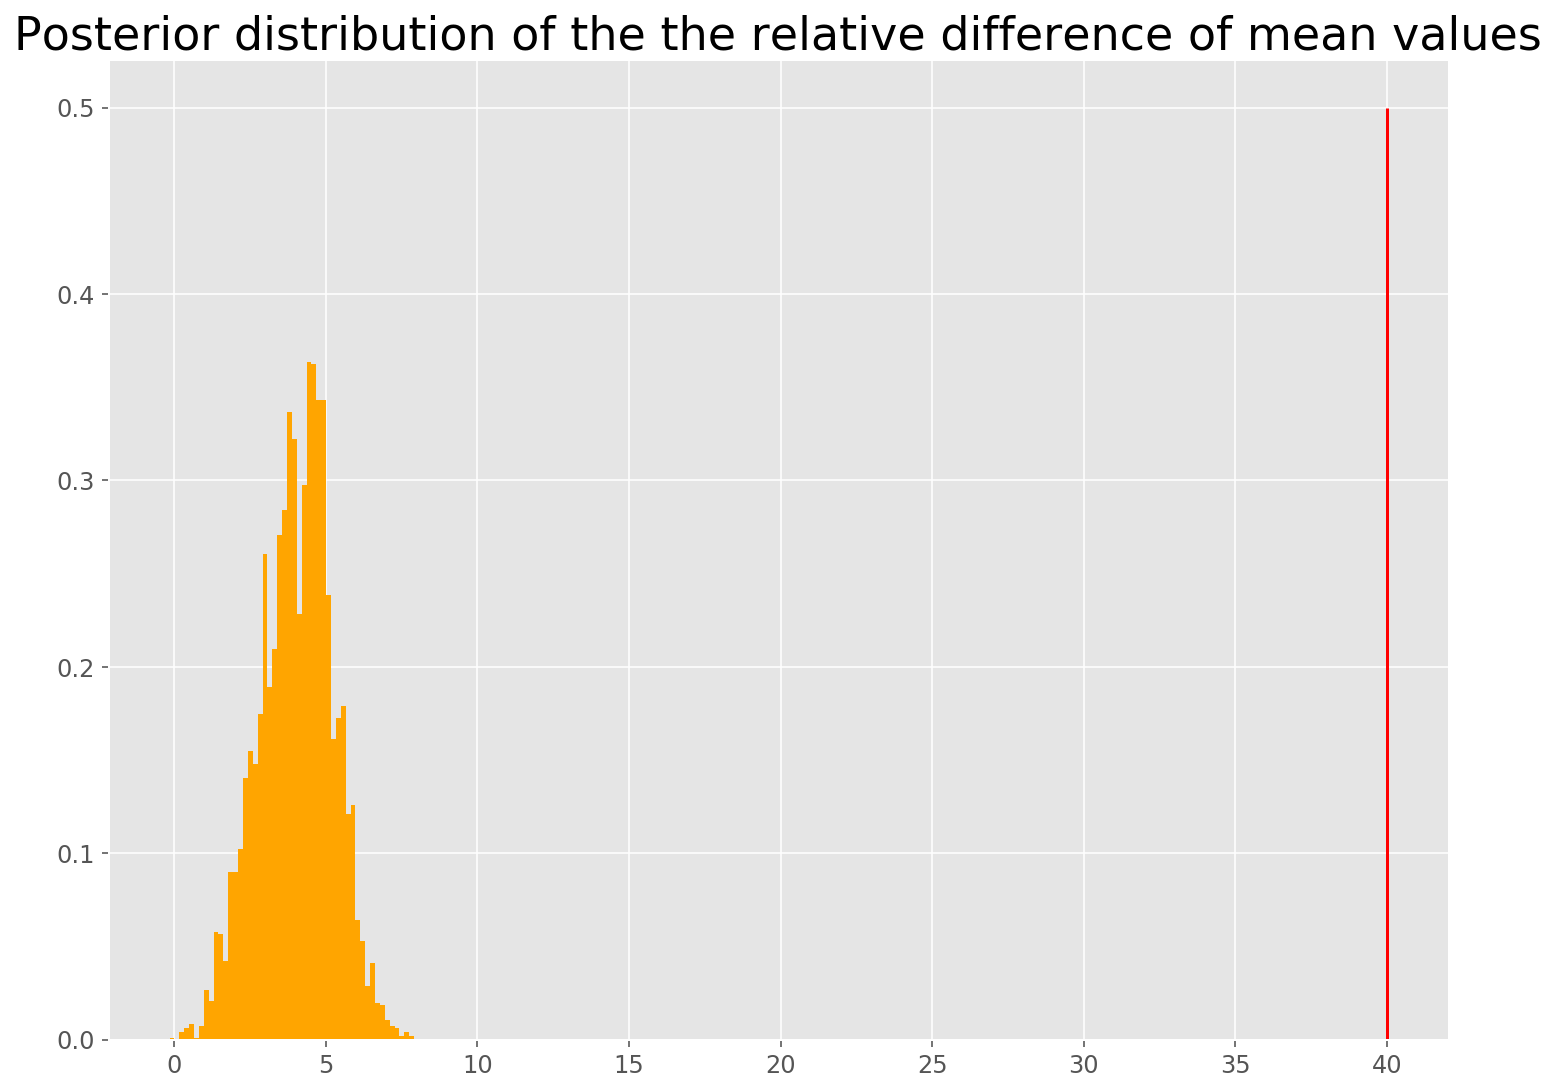

In [65]:
rel_difference = 100 * (variant_mean-control_mean)/variant_mean
prob = len(rel_difference[rel_difference > 10])/len(rel_difference)
plt.hist(rel_difference, bins=50, density=True, label='Relative differene of the mean metric', color = 'orange')
plt.title('Posterior distribution of the the relative difference of mean values')
plt.vlines(40, 0,0.5, linestyle='-', color='red', label='HDI')
print(f"The probability that the variant performed 10% greater than the control is: {round(prob*100,2)}%")
plt.show()

### Takeaways

Each additional variant appears to increase spend/day and the proportion of people placing at least 1 order, but order size did fall - which may have a negative impact on unit economics. Ultimately, fixed/variable delivery costs need to be incorporated to make a business decision, but the experiment was broadly succesful.